In [1]:
%config InlineBackend.figure_formats = ['svg']

In [2]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['FreeSans']

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
state_dim = 64
num_actions = 25
horizon = 20

In [5]:
from a5cpu_BCQ.model import BCQ
from a5cpu_BCQ.data import remap_rewards
from a5cpu_BCQ.data import EpisodicBuffer as EpisodicBufferOO
from a7cpu_BCQf.model import BCQf
from a7cpu_BCQf.data import EpisodicBuffer as EpisodicBufferFF
from a7cpu_BCQf.model import all_subactions_vec

In [6]:
from evaluate import (
    EpisodicBufferO, offline_evaluation_O,
    EpisodicBufferF, offline_evaluation_F,
)

In [7]:
from types import SimpleNamespace
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

In [8]:
df_1_best = pd.read_csv('best_BCQ_meta.csv')
df_2_best = pd.read_csv('best_BCQf_meta.csv')

In [9]:
df_1_best

,index,iteration,val_qvalues,val_wis,val_ess,epoch,created_at,version,threshold,seed
0,97,9800.0,11.247806,92.497391,202.913132,5,2021-11-15 19:47:41.309691,17,0.5,1


In [10]:
df_2_best

,index,iteration,val_qvalues,val_wis,val_ess,epoch,created_at,version,threshold,seed
0,90,9100.0,10.518903,93.28846,216.866272,5,2021-11-15 19:51:43.311177,27,0.5,4


In [11]:
df_1_best['version'].item()

17

In [12]:
model_1 = BCQ.load_from_checkpoint(
    checkpoint_path=f'../a5cpu_BCQ/logs/mimic_dBCQ/version_{df_1_best["version"].item()}/checkpoints/step={int(df_1_best["iteration"].item()-1)}.ckpt', 
    map_location=None)
model_1.eval()

model_2 = BCQf.load_from_checkpoint(
    checkpoint_path=f'../a7cpu_BCQf/logs/mimic_dBCQf/version_{df_2_best["version"].item()}/checkpoints/step={int(df_2_best["iteration"].item()-1)}.ckpt', 
    map_location=None)
model_2.eval()
model_2.all_subactions_vec = all_subactions_vec

In [13]:
test_episodes_O = EpisodicBufferO(state_dim, num_actions, horizon)
test_episodes_O.load('../data/episodes+encoded_state+knn_pibs/test_data.pt')
test_episodes_O.reward = remap_rewards(test_episodes_O.reward, SimpleNamespace(**{'R_immed': 0.0, 'R_death': 0.0, 'R_disch': 100.0}))

tmp_test_episodes_loader_O = DataLoader(test_episodes_O, batch_size=len(test_episodes_O), shuffle=False)
test_batch_O = next(iter(tmp_test_episodes_loader_O))

Episodic Buffer loaded with 2894 episides.


In [14]:
test_wis_1, test_ess_1 = model_1.offline_evaluation(test_batch_O, weighted=True, eps=0.01)
test_wis_2, test_ess_2 = offline_evaluation_O(model_2, test_batch_O, weighted=True, eps=0.01)

In [15]:
print(f'Observed Test \t WIS: {test_episodes_O.reward.sum(axis=1).mean():.2f} \t ESS: {test_episodes_O.reward.shape[0]:.2f}')
print(f'Baseline BCQ \t WIS: {test_wis_1:.2f} \t ESS: {test_ess_1:.2f}')
print(f'Factored BCQ \t WIS: {test_wis_2:.2f} \t ESS: {test_ess_2:.2f}')

Observed Test 	 WIS: 90.29 	 ESS: 2894.00
Baseline BCQ 	 WIS: 90.44 	 ESS: 178.32
Factored BCQ 	 WIS: 91.62 	 ESS: 178.32


In [16]:
states, actions, rewards, not_dones, pibs, estm_pibs = test_batch_O
n, horizon, _ = states.shape

action_pred_1 = []
for idx in tqdm(range(n)):
    lng = (not_dones[idx, :, 0].sum() + 1).item()  # all but the final transition has notdone==1

    # Predict Q-values and Imitation probabilities
    q, imt, _ = model_1.Q(states[idx])
    imt = imt.exp()
    imt = (imt / imt.max(1, keepdim=True).values > model_1.threshold).float()

    # Use large negative number to mask actions from argmax
    a_id = (imt * q + (1. - imt) * torch.finfo().min).argmax(axis=1).cpu().numpy()
    a_id[lng:] = -1
    action_pred_1.append(a_id)

100%|██████████| 2894/2894 [00:28<00:00, 100.71it/s]


In [17]:
action_pred_1 = np.array(action_pred_1)

In [18]:
action_pred_1

array([[ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       ...,
       [ 0,  5,  5, ..., -1, -1, -1],
       [ 5,  6,  8, ...,  8,  8, -1],
       [ 5,  5,  5, ...,  5,  5, -1]])

In [19]:
df_action_pred_1 = pd.DataFrame(action_pred_1.flatten(), columns=['a:action'])

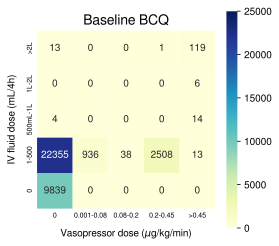

In [20]:
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(df_action_pred_1['a:action'].value_counts().sort_index().reindex(range(25), fill_value=0).values.reshape((5,5)), 
            ax=ax, square=True, cmap="YlGnBu", vmax=2.5e4, annot=True, fmt='d')
ax.invert_yaxis()

plt.title('Baseline BCQ', fontsize=14)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Vasopressor dose ($\mu$g/kg/min)")
plt.ylabel("IV fluid dose (mL/4h)")

xranges = ['0', '0.001-0.08', '0.08-0.2', '0.2-0.45', '>0.45']
yranges = ['0', '1-500', '500mL-1L', '1L-2L', '>2L']
for pos, text in enumerate(xranges):
    plt.text(pos+3/6, -0.2, text, fontsize=7, ha='center', va='center')
for pos, text in enumerate(yranges):
    plt.text(-0.2, pos+3/6, text, fontsize=7, ha='center', va='center', rotation='vertical')

plt.savefig('./fig/mimic_test_policy_BCQ.pdf', bbox_inches='tight')
plt.show()

In [21]:
states, actions, rewards, not_dones, pibs, estm_pibs = test_batch_O
n, horizon, _ = states.shape

action_pred_2 = []
for idx in tqdm(range(n)):
    lng = (not_dones[idx, :, 0].sum() + 1).item()  # all but the final transition has notdone==1

    # Predict Q-values and Imitation probabilities
    q, _, i = model_2.Q(states[idx])
    imt = F.log_softmax(i.reshape(-1, 2, 5), dim=-1).exp()
    imt = (imt / imt.max(axis=-1, keepdim=True).values > model_2.threshold).float()

    # Factored action remapping
    q = q @ model_2.all_subactions_vec.T
    imt = torch.einsum('bi,bj->bji', (imt[:,0,:], imt[:,1,:])).reshape(-1, 25)

    # Use large negative number to mask actions from argmax
    a_id = (imt * q + (1. - imt) * torch.finfo().min).argmax(axis=1).cpu().numpy()
    a_id[lng:] = -1
    action_pred_2.append(a_id)

100%|██████████| 2894/2894 [00:32<00:00, 89.31it/s] 


In [22]:
action_pred_2 = np.array(action_pred_2)

In [23]:
action_pred_2

array([[ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       ...,
       [ 0,  5,  5, ..., -1, -1, -1],
       [ 5,  5,  8, ...,  8,  8, -1],
       [ 5,  5,  5, ...,  5,  5, -1]])

In [24]:
df_action_pred_2 = pd.DataFrame(action_pred_2.flatten(), columns=['a:action'])

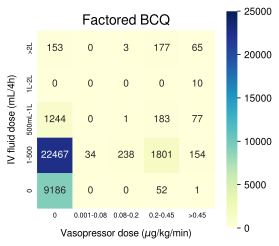

In [25]:
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(df_action_pred_2['a:action'].value_counts().sort_index().reindex(range(25), fill_value=0).values.reshape((5,5)), 
            ax=ax, square=True, cmap="YlGnBu", vmax=2.5e4, annot=True, fmt='d')
ax.invert_yaxis()

plt.title('Factored BCQ', fontsize=14)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Vasopressor dose ($\mu$g/kg/min)")
plt.ylabel("IV fluid dose (mL/4h)")

xranges = ['0', '0.001-0.08', '0.08-0.2', '0.2-0.45', '>0.45']
yranges = ['0', '1-500', '500mL-1L', '1L-2L', '>2L']
for pos, text in enumerate(xranges):
    plt.text(pos+3/6, -0.2, text, fontsize=7, ha='center', va='center')
for pos, text in enumerate(yranges):
    plt.text(-0.2, pos+3/6, text, fontsize=7, ha='center', va='center', rotation='vertical')

plt.savefig('./fig/mimic_test_policy_BCQf.pdf', bbox_inches='tight')
plt.show()

In [26]:
states, actions, rewards, not_dones, pibs, estm_pibs = test_batch_O
n, horizon, _ = states.shape

action_obs = []
for idx in tqdm(range(n)):
    lng = (not_dones[idx, :, 0].sum() + 1).item()  # all but the final transition has notdone==1

    # Predict Q-values and Imitation probabilities
    q, imt, _ = model_1.Q(states[idx])
    imt = imt.exp()
    imt = (imt / imt.max(1, keepdim=True).values > model_1.threshold).float()

    # Use large negative number to mask actions from argmax
    a_id = actions[idx, :, 0].cpu().numpy()
    a_id[lng:] = -1
    action_obs.append(a_id)

100%|██████████| 2894/2894 [00:39<00:00, 73.25it/s] 


In [27]:
action_obs = np.array(action_obs)

In [28]:
action_obs

array([[ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       ...,
       [10, 10,  5, ..., -1, -1, -1],
       [12,  7,  7, ...,  7,  7, -1],
       [ 5,  5,  5, ...,  5,  5, -1]])

In [29]:
df_action_obs = pd.DataFrame(action_obs.flatten(), columns=['a:action'])

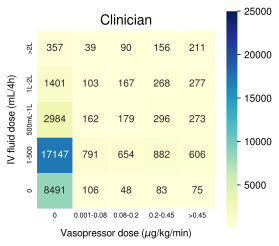

In [30]:
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(df_action_obs['a:action'].value_counts().sort_index().reindex(range(25), fill_value=0).values.reshape((5,5)), 
            ax=ax, square=True, cmap="YlGnBu", vmax=2.5e4, annot=True, fmt='d')
ax.invert_yaxis()

plt.title('Clinician', fontsize=14)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Vasopressor dose ($\mu$g/kg/min)")
plt.ylabel("IV fluid dose (mL/4h)")

xranges = ['0', '0.001-0.08', '0.08-0.2', '0.2-0.45', '>0.45']
yranges = ['0', '1-500', '500mL-1L', '1L-2L', '>2L']
for pos, text in enumerate(xranges):
    plt.text(pos+3/6, -0.2, text, fontsize=7, ha='center', va='center')
for pos, text in enumerate(yranges):
    plt.text(-0.2, pos+3/6, text, fontsize=7, ha='center', va='center', rotation='vertical')

plt.savefig('./fig/mimic_test_policy_clinician.pdf', bbox_inches='tight')
plt.show()

In [40]:
test_data = torch.load('../data/episodes+encoded_state+knn_pibs/test_data.pt')

In [36]:
df_obs = df_action_obs[df_action_obs['a:action'] != -1] 
df_pred_1 = df_action_pred_1[df_action_pred_1['a:action'] != -1]
df_pred_2 = df_action_pred_2[df_action_pred_2['a:action'] != -1]

In [38]:
(df_obs == df_obs).mean().item(), (df_obs == df_pred_1).mean().item(), (df_obs == df_pred_2).mean().item()

(1.0, 0.6241700608157117, 0.623667912737823)

In [39]:
(df_pred_1 == df_pred_2).mean().item()

0.8767505439937511

In [49]:
df_action_pred_1.values.flatten().reshape((-1, 20))

array([[ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       ...,
       [ 0,  5,  5, ..., -1, -1, -1],
       [ 5,  6,  8, ...,  8,  8, -1],
       [ 5,  5,  5, ...,  5,  5, -1]])

In [63]:
(
    (df_action_obs.values.flatten().reshape((-1, 20)) == -1) | 
    (df_action_obs.values.flatten().reshape((-1, 20)) == test_episodes_O.action.squeeze().numpy())
).all()

True

In [67]:
mismatch_mask = (df_action_pred_1.values.flatten().reshape((-1, 20)) != (df_action_pred_2.values.flatten().reshape((-1, 20))))

In [80]:
test_data['acuities'][:, :-1, 0][mismatch_mask].numpy().mean(), test_data['acuities'][:, :-1, 0][mismatch_mask].numpy().std()

(8.207787, 4.201663)

In [78]:
match_mask = (
    (df_action_pred_1.values.flatten().reshape((-1, 20)) != -1) &
    (df_action_pred_1.values.flatten().reshape((-1, 20)) == (df_action_pred_2.values.flatten().reshape((-1, 20))))
)

In [81]:
test_data['acuities'][:, :-1, 0][match_mask].numpy().mean(), test_data['acuities'][:, :-1, 0][match_mask].numpy().std()

(5.4672585, 3.3563888)

In [84]:
((df_action_pred_1.values.flatten().reshape((-1, 20)) == 8) & (df_action_pred_2.values.flatten().reshape((-1, 20)) == 10)).sum()

44

In [88]:
# action index 8 to 10
test_data['acuities'][:, :-1, 0][(df_action_pred_1.values.flatten().reshape((-1, 20)) == 8) & (df_action_pred_2.values.flatten().reshape((-1, 20)) == 10)].mean()

tensor(7.5455)

In [91]:
df_compare = pd.DataFrame([
    df_pred_1['a:action'].rename('baseline_BCQ'),
    df_pred_2['a:action'].rename('factored_BCQ'),
]).T

In [92]:
df_compare

,baseline_BCQ,factored_BCQ
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
57874,5,5
57875,5,5
57876,5,5
57877,5,5


In [112]:
df_compare.value_counts().sort_index().reindex(pd.MultiIndex.from_product([range(25), range(25)]), fill_value=0)

0   0     9013
    1        0
    2        0
    3       46
    4        1
          ... 
24  20      25
    21       0
    22       3
    23      26
    24      23
Length: 625, dtype: int64

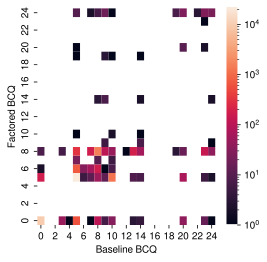

In [114]:
fig, ax = plt.subplots(figsize=(4,4))
# sns.histplot(df_compare, x='baseline_BCQ', y='factored_BCQ', hue_norm=matplotlib.colors.LogNorm())
sns.heatmap(df_compare.value_counts().sort_index() \
            .reindex(pd.MultiIndex.from_product([range(25), range(25)]), fill_value=0).values.reshape((25,25)), norm=matplotlib.colors.LogNorm())
#              sns.heatmap(df_action_obs['a:action'].value_counts().sort_index().reindex(range(25), fill_value=0).values.reshape((5,5)), 
#             ax=ax, square=True, cmap="YlGnBu", vmax=2.5e4, annot=True, fmt='d')
plt.xlabel("Baseline BCQ")
plt.ylabel("Factored BCQ")
ax.invert_yaxis()
plt.show()

In [41]:
test_data.keys()

dict_keys(['index', 'icustayids', 'lengths', 'times', 'notdones', 'demographics', 'observations', 'acuities', 'rewards', 'actions', 'actionvecs', 'subactions', 'subactionvecs', 'statevecs', 'pibs', 'estm_pibs'])

In [53]:
test_data['actions'][:, 1:]

tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        ...,
        [10, 10,  5,  ...,  0,  0,  0],
        [12,  7,  7,  ...,  7,  7,  0],
        [ 5,  5,  5,  ...,  5,  5,  0]])

In [69]:
(test_data['actions'][:, 1:] == test_episodes_O.action.squeeze()).all()

tensor(True)